In [20]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
# W_LEV_AVG	= ค่าระดับน้ำทะเล หน่วยเมตร
# Load your dataset
df = pd.read_csv("data_preprocess/raw_data/dmr_tidal-level-phuket-tidegauge-2013_2023.csv")
# ลบช่องว่างเกินออก (กันกรณีมี space แปลก ๆ)
df["DATE"] = df["DATE"].str.strip()

# เติมเลข 0 ให้ชั่วโมงหลักเดียว และเติม ":00" ถ้าขาดวินาที
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{1}):(\d{2})$", r"\1 0\2:\3:00", regex=True)
df["DATE"] = df["DATE"].str.replace(r"(\d{1,2}/\d{1,2}/\d{4}) (\d{2}:\d{2})$", r"\1 \2:00", regex=True)

# แปลงเป็น datetime โดยกำหนด dayfirst=True
df["DATE"] = pd.to_datetime(df["DATE"], format="%d/%m/%Y %H:%M:%S", dayfirst=True)
df.set_index('DATE', inplace=True)
df = df.drop(columns=["TW_ID", "TW_NAME", "UTM_E", 'UTM_N'], axis=1)
df.dropna(inplace=True)

In [87]:
Q1 = df['W_LEV_AVG'].quantile(0.25)
Q3 = df['W_LEV_AVG'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['W_LEV_AVG'] >= Q1 - 1.5 * IQR) & (df['W_LEV_AVG'] <= Q3 + 1.5 * IQR)]

In [88]:
# Extract time components
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear

In [89]:
import ephem
# ฟังก์ชันหาข้างขึ้นข้างแรม
def get_moon_phase(dt):
    moon_phase = ephem.Moon(dt).phase  # คำนวณเฟสของดวงจันทร์
    return round(moon_phase)  # ปัดค่า phase ให้เป็นจำนวนเต็ม (0-29)

# คำนวณข้างขึ้นข้างแรม และเพิ่มเป็นคอลัมน์ใหม่
df["moon_phase"] = df.index.to_series().apply(get_moon_phase)

# เพิ่มคอลัมน์ full_moon_days (ขึ้น 15 ค่ำ) และ dark_moon_days (แรม 15 ค่ำ)
df["full_moon_days"] = (df["moon_phase"] == 15).astype(int) #(ขึ้น 15 ค่ำ)
df["dark_moon_days"] = (df["moon_phase"] == 29).astype(int) #(แรม 15 ค่ำ)

In [90]:
# คำนวณค่า max, min, avg ของแต่ละวัน
df['W_LEV_AVG_max_of_day'] = df.groupby(df.index.date)['W_LEV_AVG'].transform('max')
df['W_LEV_AVG_min_of_day'] = df.groupby(df.index.date)['W_LEV_AVG'].transform('min')

In [91]:
df = df.resample("H").mean()

In [92]:
df['W_LEV_AVG_prev1'] = df['W_LEV_AVG'].shift(1)
df['W_LEV_AVG_prev7'] = df['W_LEV_AVG'].shift(7)
df.dropna(inplace=True)

In [93]:
df['W_LEV_AVG_rolling7'] = df['W_LEV_AVG'].rolling(window=7).mean()
df.dropna(inplace=True)

In [94]:
df

,W_LEV_AVG,year,month,day,day_of_week,day_of_year,moon_phase,full_moon_days,dark_moon_days,W_LEV_AVG_max_of_day,W_LEV_AVG_min_of_day,W_LEV_AVG_prev1,W_LEV_AVG_prev7,W_LEV_AVG_rolling7
DATE,,,,,,,,,,,,,,
2013-10-01 20:00:00,0.612350,2013.0,10.0,1.0,1.0,274.0,11.000000,0.0,0.0,0.6483,-1.0944,0.414050,-0.944783,-0.285833
2013-10-01 21:00:00,0.606317,2013.0,10.0,1.0,1.0,274.0,10.666667,0.0,0.0,0.6483,-1.0944,0.612350,-1.078483,-0.045148
2013-10-01 22:00:00,0.397000,2013.0,10.0,1.0,1.0,274.0,10.000000,0.0,0.0,0.6483,-1.0944,0.606317,-0.985550,0.152360
2013-10-01 23:00:00,0.026983,2013.0,10.0,1.0,1.0,274.0,10.000000,0.0,0.0,0.6483,-1.0944,0.397000,-0.719017,0.258931
2013-10-02 00:00:00,-0.425300,2013.0,10.0,2.0,2.0,275.0,10.000000,0.0,0.0,0.9296,-1.2853,0.026983,-0.329267,0.245212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-1.144383,2023.0,12.0,31.0,6.0,365.0,79.500000,0.0,0.0,0.8750,-1.5208,-1.174217,0.324467,-0.526626
2023-12-31 20:00:00,-0.888383,2023.0,12.0,31.0,6.0,365.0,79.000000,0.0,0.0,0.8750,-1.5208,-1.144383,0.336617,-0.701626
2023-12-31 21:00:00,-0.470750,2023.0,12.0,31.0,6.0,365.0,79.000000,0.0,0.0,0.8750,-1.5208,-0.888383,0.138883,-0.788717


In [95]:
exp = setup(data=df, target='W_LEV_AVG', fold=10, train_size=0.8, session_id=123, iterative_imputation_iters=100, remove_outliers = True, use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,123
1,Target,W_LEV_AVG
2,Target type,Regression
3,Original data shape,"(88388, 14)"
4,Transformed data shape,"(84852, 14)"
5,Transformed train set shape,"(67174, 14)"
6,Transformed test set shape,"(17678, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [96]:
best_model = exp.compare_models()  # Find the best regression model

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0369,0.0027,0.0521,0.9954,0.0323,0.2831,3.9530
rf,Random Forest Regressor,0.0399,0.0031,0.0560,0.9947,0.0347,0.3185,7.7120
lightgbm,Light Gradient Boosting Machine,0.0454,0.0039,0.0623,0.9934,0.0385,0.3608,2.0730
ridge,Ridge Regression,0.0458,0.0042,0.0650,0.9928,0.0409,0.3774,0.7470
br,Bayesian Ridge,0.0458,0.0042,0.0650,0.9928,0.0409,0.3774,0.8120
lr,Linear Regression,0.0458,0.0042,0.0650,0.9928,0.0409,0.3774,0.7460
gbr,Gradient Boosting Regressor,0.0637,0.0069,0.0831,0.9883,0.0517,0.4728,11.4120
dt,Decision Tree Regressor,0.0613,0.0075,0.0864,0.9874,0.0530,0.5461,1.4090
lar,Least Angle Regression,0.1011,0.0236,0.1335,0.9605,0.0805,0.9529,0.7250
ada,AdaBoost Regressor,0.1908,0.0544,0.2331,0.9081,0.1399,1.1801,6.1120


In [51]:
best_model = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0270,0.0019,0.0437,0.8954,0.0324,0.4270
1,0.0283,0.0020,0.0446,0.9161,0.0335,0.3853
2,0.0264,0.0014,0.0380,0.9385,0.0296,0.5815
3,0.0282,0.0017,0.0407,0.9231,0.0312,0.4083
4,0.0258,0.0014,0.0378,0.9257,0.0309,0.2319
5,0.0275,0.0024,0.0487,0.8861,0.0394,0.6685
6,0.0287,0.0017,0.0413,0.9120,0.0334,0.5349
7,0.0260,0.0013,0.0359,0.9350,0.0281,0.3556
8,0.0229,0.0009,0.0306,0.9463,0.0251,0.4431


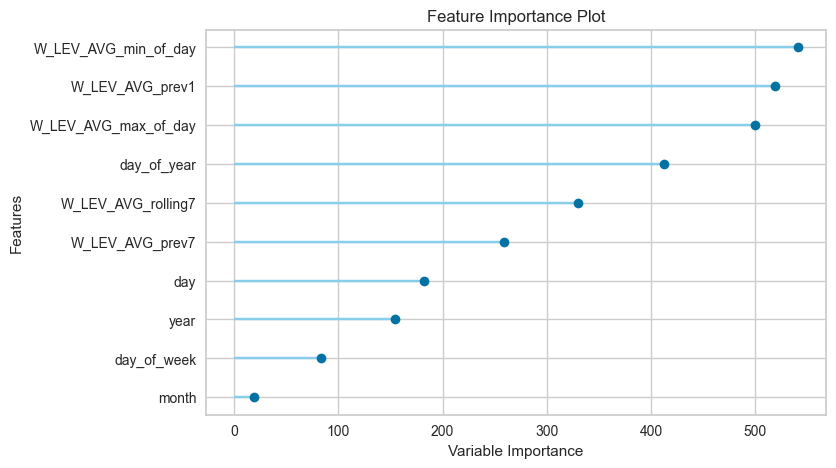

In [52]:
plot_model(best_model, plot='feature')

In [53]:
prediction = exp.predict_model(best_model, data=df)
prediction

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0191,0.0010,0.0313,0.9522,0.0227,0.2975


,year,month,day,day_of_week,day_of_year,W_LEV_AVG_max_of_day,W_LEV_AVG_min_of_day,W_LEV_AVG_prev1,W_LEV_AVG_prev7,W_LEV_AVG_rolling7,W_LEV_AVG,prediction_label
DATE,,,,,,,,,,,,
2013-10-14,2013.0,10.0,14.0,0.0,287.0,0.5954,-0.9504,-0.161214,-0.248965,-0.198766,-0.093785,-0.137681
2013-10-15,2013.0,10.0,15.0,1.0,288.0,0.8828,-1.1860,-0.093785,-0.272054,-0.173422,-0.094649,-0.091168
2013-10-16,2013.0,10.0,16.0,2.0,289.0,1.0342,-1.3453,-0.094649,-0.263389,-0.156449,-0.144576,-0.130596
2013-10-17,2013.0,10.0,17.0,3.0,290.0,1.1369,-1.5340,-0.144576,-0.234950,-0.151874,-0.202922,-0.192330
2013-10-18,2013.0,10.0,18.0,4.0,291.0,1.2090,-1.6356,-0.202922,-0.188781,-0.163344,-0.269070,-0.250244
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,2023.0,12.0,27.0,2.0,361.0,0.8730,-1.7687,-0.545801,-0.334331,-0.449429,-0.539991,-0.514610
2023-12-28,2023.0,12.0,28.0,3.0,362.0,0.9097,-1.7881,-0.539991,-0.300062,-0.484668,-0.546736,-0.516032
2023-12-29,2023.0,12.0,29.0,4.0,363.0,0.9433,-1.7645,-0.546736,-0.344672,-0.505885,-0.493192,-0.507321
